In [1]:
# Load dataset

import pandas as pd

data_xls = pd.read_excel('Training data.xlsx', 'Info', index_col=None)
data_xls.to_csv('Info.csv', encoding='utf-8',index = False)
data_xls = pd.read_excel('Training data.xlsx', 'TPR', index_col=None)
data_xls.to_csv('TPR.csv', encoding='utf-8', index = False)

infoSet = pd.read_csv("Info.csv", header = None, skiprows=[0])
TPRSet = pd.read_csv("TPR.csv", header = None, skiprows=[0])

# TPRSet

In [2]:
# Merge info set and TPR set
from sklearn.decomposition import PCA

aggregation_functions = {2: 'mean', 3: 'mean', 4: 'mean', 5: 'mean', 6: 'mean'}

TPRaggreg = TPRSet.groupby(TPRSet[0]).aggregate(aggregation_functions)
mergeSet = pd.merge(infoSet.iloc[:, [True, True, True, False, False, False, False]], TPRaggreg.iloc[:, [True, True, True, True, True]], on=0)
# mergeSet

In [3]:
# Extract feature list and clean strings
import numpy as np

def str_trim(series):
    series = series.replace(' ', np.nan)
    series = series.replace('', np.nan, regex=True)
    series = series.replace("0", np.nan, regex=True)
    
    feature = pd.DataFrame(series.str.split(',').explode())
    feature = feature.drop_duplicates(subset=None, keep='first', inplace=False)
    feature = feature.replace('', np.nan)
    feature = feature.dropna()

    return series, feature

bacteria = infoSet.iloc[:, 5]
bacteria = bacteria.rename("bacteria")
bacteriaSet, bacteria_feature= str_trim(bacteria)
bacteria_feature = bacteria_feature.to_numpy().flatten()

common = infoSet.iloc[:, 3]
common = common.rename("common")
commonSet, commonFeature = str_trim(common)
commonFeature = commonFeature.to_numpy().flatten()
# mergeSet[5]

In [4]:
# Create one hot encoding
def extract_df(ser, features):
    df= pd.DataFrame()
    for feature in features:
        id = 0
        new_list = []
        for element in ser:
            if feature == element:
                new_list.append(1)
            else:
                new_list.append(0)
    
        df[feature] = new_list
    return df
            
#origin_ant
bacteria_df = extract_df(bacteriaSet, bacteria_feature)
common_df = extract_df(commonSet, commonFeature)
# common_df

In [5]:
# Create cleaned data set
import numpy as np
from sklearn import preprocessing


# 創造 dummy variables
label_encoder = preprocessing.LabelEncoder()
encoded_no = label_encoder.fit_transform(mergeSet[0])

# 建立訓練與測試資料
patient_x = pd.concat([mergeSet, bacteria_df, common_df], axis=1)
patient_x = patient_x.iloc[:, 1:]
patient_y = infoSet.iloc[:, 6]

patient_x
# type(patient_x)

,1,2_x,2_y,3,4,5,6,Escherichia coli,Yeast-like,Staphylococcus aureus (MRSA),...,Acinetobacter baumannii,Staphylococcus aureus,Candida tropicalis,Enterobacter cloacae ssp cloacae,Candida glabrata,Corynebacterium striatum,Staphylococcus haemolyticus,1,2,4
0,1,44,37.818421,87.764706,21.294118,113.055556,67.823529,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,2,75,37.000000,84.684211,19.750000,131.789474,70.684211,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2,92,37.012500,66.777778,18.312500,141.444444,65.166667,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,42,37.036364,75.866667,17.533333,130.882353,86.529412,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,41,37.219048,82.352941,16.705882,111.250000,70.125000,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,2,75,37.419231,99.687500,19.562500,126.000000,75.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
316,2,40,37.597143,90.576923,17.888889,142.842105,72.368421,0,0,0,...,0,0,0,0,1,0,0,1,0,0
317,2,64,37.847727,91.411765,19.266667,138.687500,74.500000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,1,57,37.657143,103.185185,18.000000,172.444444,107.851852,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
# Min max scaler seems to be unhelpful
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# scaler.fit(patient_x)
# print(scaler.data_max_)
# patient_x = scaler.transform(patient_x)
# print(patient_x)

In [18]:
# Reduce demensionality
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, mutual_info_classif
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(0.1))
patient_x = sel.fit_transform(patient_x)

# Min max scaler seems to be unhelpful
# kb = SelectKBest(mutual_info_classif, k=10).fit(patient_x, patient_y)
# patient_x = kb.transform(patient_x)
patient_x

array([[  1.        ,  44.        ,  37.81842105, ..., 113.05555556,
         67.82352941,   1.        ],
       [  2.        ,  75.        ,  37.        , ..., 131.78947368,
         70.68421053,   1.        ],
       [  2.        ,  92.        ,  37.0125    , ..., 141.44444444,
         65.16666667,   0.        ],
       ...,
       [  2.        ,  64.        ,  37.84772727, ..., 138.6875    ,
         74.5       ,   0.        ],
       [  1.        ,  57.        ,  37.65714286, ..., 172.44444444,
        107.85185185,   0.        ],
       [  2.        ,  82.        ,  37.35714286, ..., 125.52631579,
         76.52631579,   0.        ]])

In [8]:
sel = VarianceThreshold(threshold=(0.1))
patient_x = sel.fit_transform(patient_x)


In [9]:
# Seperate training set and testing set

from sklearn import model_selection
train_x, test_x, train_y, test_y = model_selection.train_test_split(patient_x, patient_y, test_size = 0.2)
# Transform it to np array, for convenience
train_y = np.array(train_y)


In [10]:
# My Logistic regression
def sigmoid(z):
    return 1 / (1 + np.exp(-z, dtype=np.float128))

def average_gradient(model, train_x, train_y):
    gradient = np.zeros(len(model))
    for index in range(len(train_x)):
        gradient += np.multiply((sigmoid(model.T.dot(train_x[index])) - train_y[index]), train_x[index])
    return gradient / len(gradient)

def logistic_train(train_x, train_y):
    model = np.zeros(len(train_x[0]))
    
    learning_rate = 1
    limit = 1000
    for i in range(limit):
        model = model - learning_rate * average_gradient(model, train_x, train_y)
        learning_rate *= 0.97 
    return model

def logistic_predict(model, data):
    result = []
    for x in data:
        if sigmoid(model.dot(x)) > 0.7:
            result.append(1)
        else:
            result.append(0)
    return result

def logistic_predict_prob(model, data):
    return sigmoid(model * data)

def visulization(model):
    pass

model = logistic_train(train_x, train_y)
print(model)
test_y_predicted = logistic_predict(model, test_x)


<ipython-input-10-6bb870c01b97>:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z, dtype=np.float128))


[ -16.65266059 -173.66927556  152.8260817   547.11365673  -20.21281225
 -180.48215227 -258.10195544   -4.09434632]


In [11]:
# Validate accuracy
from sklearn import metrics

# Score
accuracy = metrics.accuracy_score(test_y, test_y_predicted)
print(accuracy)
# f1 score
f1 = metrics.f1_score(test_y, test_y_predicted)
print(f1)

0.859375
0.64


In [12]:
from sklearn import preprocessing, linear_model
logistic_regr = linear_model.LogisticRegression()
logistic_regr.fit(train_x, train_y)

# 印出係數
# print(logistic_regr.coef_)

# 印出截距
# print(logistic_regr.intercept_ )
test_y_predicted = logistic_regr.predict(test_x)

accuracy = metrics.accuracy_score(test_y, test_y_predicted)
print(accuracy)
# f1 score
f1 = metrics.f1_score(test_y, test_y_predicted)
print(f1)

0.796875
0.23529411764705882


/home/daniellin/Desktop/homework/dm_pj1/ENV/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


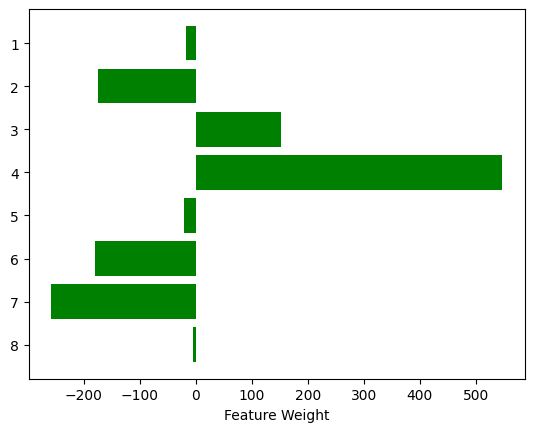

In [13]:
import matplotlib.pyplot as plt
plt.rcdefaults()    #  回覆預設的RC引數
fig,ax =plt.subplots()    #   ax為子圖

features_label = list(range(1, len(model) + 1))
y_pos = np.arange(len(model))

# exp_model = np.log(model)
ax.barh(y_pos, model, align='center',color='green',ecolor='black')

ax.set_yticks(y_pos)   #   設定縱座標的刻度
ax.set_yticklabels(features_label) #   設定縱座標的標籤(人名)
ax.invert_yaxis()  #   把Y反轉,取消這一行執行一下就明白了
ax.set_xlabel('Feature Weight')   #   顯示X軸標籤

plt.show()  #  顯示圖片

In [14]:
# from sklearn import metrics, svm
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
# from sklearn.model_selection import cross_val_score

# # Create models
# forest = RandomForestClassifier(n_estimators = 100)
# extraTrees = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
# svc = svm.SVC(probability=True)
# voting = VotingClassifier(estimators=[('rf', forest), ('et', extraTrees), ('svm', svc)], voting='soft')

# for clf, label in zip([forest, extraTrees, svc, voting], ['Random Forest', 'Extra Trees', 'SVM', 'Voting Classifier']):
#     scores = cross_val_score(clf, patient_x, patient_y, cv=5, scoring='accuracy')
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
# voting_fit = voting.fit(train_x, train_y)

# # Predict
# test_y_predicted = voting.predict(test_x)

In [15]:
# # Cal AUC
# fpr, tpr, thresholds = metrics.roc_curve(test_y, test_y_predicted)
# auc = metrics.auc(fpr, tpr)
# print(auc)

In [16]:
# # f1 score
# f1 = metrics.f1_score(test_y, test_y_predicted)
# f1

In [17]:
# Testing
# data_xls = pd.read_excel('Testing data.xlsx', 'Info', index_col=None)
# data_xls.to_csv('TestingInfo.csv', encoding='utf-8',index = False)
# data_xls = pd.read_excel('Testing data.xlsx', 'TPR', index_col=None)
# data_xls.to_csv('TestingTPR.csv', encoding='utf-8', index = False)

# infoSet = pd.read_csv("TestingInfo.csv", header = None, skiprows=[0])
# TPRSet = pd.read_csv("TestingTPR.csv", header = None, skiprows=[0])

# aggregation_functions = {2: 'mean', 3: 'mean', 4: 'mean', 5: 'mean', 6: 'mean'}

# TPRaggreg = TPRSet.groupby(TPRSet[0]).aggregate(aggregation_functions)
# mergeSet = pd.merge(infoSet.iloc[:, [True, True, True, False, False, False]], TPRaggreg.iloc[:, [True, True, True, True, True]], on=0)

# # Extract feature
# bacteria = infoSet.iloc[:, 5]
# bacteria = bacteria.rename("bacteria")
# bacteriaSet, bacteria_feature_not_used = str_trim(bacteria)
# # bacteria_feature_not_used = bacteria_feature_not_used.to_numpy().flatten()

# common = infoSet.iloc[:, 3]
# common = common.rename("common")
# commonSet, commonFeature = str_trim(common)
# commonFeature = commonFeature.to_numpy().flatten()

# # One Hot encoding
# bacteria_df = extract_df(bacteriaSet, bacteria_feature)
# common_df = extract_df(commonSet, commonFeature)

# # Concate
# test_x = pd.concat([mergeSet, bacteria_df, common_df], axis=1)
# test_x = test_x.iloc[:, 1:]

# # Cover select k best mask
# mask = kb.get_support()

# test_x = test_x.iloc[:,mask]

# test_y_predicted = voting.predict(test_x)

# test_y_predicted